# Dati non gaussiani e categoriali {#sec-cfa-cat-data}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
here::here("code", "_common.R") |>
    source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(lavaan, psych, BifactorIndicesCalculator, semPlot)

Caricamento dei namespace richiesti: pacman



## Introduzione

Nel materiale precedente di questa dispensa è stato discusso l'utilizzo dello stimatore di massima verosimiglianza (ML), comunemente adottato nei modelli di Analisi Fattoriale Confermativa (CFA) e Structural Equation Modeling (SEM) presenti nella letteratura di ricerca applicata. Tuttavia, l'uso dello stimatore ML è appropriato esclusivamente per dati multivariati normali, ovvero quando la distribuzione congiunta delle variabili continue è normalmente distribuita. In presenza di dati continui che presentano una forte deviazione dalla normalità, come asimmetria o curtosi elevate, o quando gli indicatori non sono a livello di scala intervallare (per esempio, dati binari, politomici o ordinali), è consigliabile adottare stimatori alternativi al ML.

## Dati non Gaussiani e Stimatori Alternativi

Nonostante la stima di massima verosimiglianza (ML) rimanga robusta a piccole deviazioni dalla normalità, situazioni di marcata non normalità richiedono l'adozione di stimatori alternativi per preservare l'affidabilità statistica. L'uso del ML in tali condizioni può portare a:

- Sovrastima della statistica chi-quadrato ($\chi^2$) del modello;
- Sottostima degli indici di bontà di adattamento, come il Tucker-Lewis Index (TLI) e il Comparative Fit Index (CFI);
- Sottostima degli errori standard delle stime dei parametri.

Questi problemi si accentuano in campioni di dimensioni ridotte. Per mitigare tali effetti, si raccomanda l'uso dei seguenti stimatori:

1. **GLS (Generalized Least Squares)**: 
   - **Uso**: Adatto per dati completi senza valori mancanti.
   - **Funzione di Discrepanza**: La funzione di discrepanza del GLS misura quanto la matrice di covarianza stimata dal modello ($\Sigma(\theta)$) si differenzia dalla matrice di covarianza osservata ($S$). La formula $F_{\text{GLS}}(S, \Sigma(\theta)) = \frac{1}{2} \text{traccia}(S - \Sigma(\theta))^2$ utilizza la traccia (la somma degli elementi sulla diagonale principale della matrice) per quantificare questa differenza.
   - **Interpretazione**: Un valore più basso della funzione di discrepanza indica un migliore adattamento del modello ai dati.

2. **WLS (Weighted Least Squares)**: 
   - **Uso**: Conosciuto come stimatore Asintoticamente Libero da Distribuzione (ADF), utile per dati complessi.
   - **Funzione di Discrepanza**: $F_{\text{ADF}}(S, \Sigma(\theta)) = \text{vecs}(S - \Sigma(\theta))'W\text{vecs}(S - \Sigma(\theta))$. Qui, `vecs()` trasforma la matrice di covarianza in un vettore (prendendo solo la parte inferiore della matrice), e `W` è una matrice di pesi che dà diversa importanza ai vari elementi nel calcolo della discrepanza.
   - **Interpretazione**: Un valore più basso indica che il modello si adatta meglio ai dati, tenendo conto della ponderazione specifica di `W`.

3. **DWLS (Diagonally Weighted Least Squares)**: 
   - **Uso**: Una versione semplificata di WLS.
   - **Funzione di Discrepanza**: $F_{\text{DWLS}}(S, \Sigma(\theta)) = \text{vecs}(S - \Sigma(\theta))'D\text{vecs}(S - \Sigma(\theta))$, dove `D` è una matrice di pesi diagonale.
   - **Interpretazione**: Simile a WLS, ma semplifica i calcoli usando solo una matrice di pesi diagonale, che considera solo gli elementi sulla diagonale della matrice di covarianza.

4. **ULS (Unweighted Least Squares)**: 
   - **Uso**: Considerato un caso speciale di WLS.
   - **Funzione di Discrepanza**: $F_{\text{ULS}}(S, \Sigma(\theta)) = \text{vecs}(S - \Sigma(\theta))'\text{vecs}(S - \Sigma(\theta))$. Qui, si utilizza una matrice di identità come peso, il che significa che tutti gli elementi hanno lo stesso peso nel calcolo della discrepanza.
   - **Interpretazione**: Un approccio più diretto rispetto a WLS, che non pondera gli elementi in modo diverso. Un valore più basso indica un migliore adattamento del modello.

In sintesi, questi stimatori vengono utilizzati per valutare quanto bene un modello SEM si adatti ai dati. Differiscono nel modo in cui trattano le discrepanze tra i dati osservati e quelli stimati dal modello, e ciascuno ha specifiche situazioni in cui risulta più appropriato.

### ML Robusto: Adattamento in Presenza di Non Normalità

Oltre ai quattro metodi di stima già menzionati (GLS, WLS, DWLS, ULS), un altro stimatore importante nel contesto del Structural Equation Modeling (SEM) è il **ML Robusto** (*Robust Maximum Likelihood*). Il ML Robusto è una variante della stima di massima verosimiglianza tradizionale, progettata per migliorare l'affidabilità statistica quando i dati deviano significativamente dalla normalità. Questo stimatore:
- **Corregge la Sovrastima di $\chi^2$**: Offre una correzione alla sovrastima della statistica chi-quadrato tipica del ML tradizionale.
- **Errore Standard Affidabile**: Fornisce stime più accurate degli errori standard, cruciali in presenza di non normalità.
- **Migliora Indici di Bontà di Adattamento**: Offre valutazioni più precise di indici come TLI e CFI.

In conclusione, l'adozione di stimatori come il ML Robusto o il WLS si rivela essenziale per garantire l'integrità delle analisi SEM in presenza di dati non normali, specialmente quando le dimensioni del campione sono limitate o i dati presentano caratteristiche complesse.

**Esempio.** Esaminiamo qui un esempio discusso da {cite:t}`brown2015confirmatory` (tabelle 9.5 -- 9.7). 

In [2]:
d <- readRDS(here::here("data", "brown_table_9_5_data.RDS"))
head(d)

,x1,x2,x3,x4,x5
,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,4,2,2,1,1
5,1,0,1,6,0
6,0,0,0,0,0


Le statistiche descrittive di questo campione di dati mostrano valori eccessivi di asimmetria e di curtosi.

In [3]:
psych::describe(d)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
x1,1,870,1.4701149,2.172832,0,1.0086207,0,0,8,8,1.506406,1.252591,0.07366591
x2,2,870,0.8229885,1.601474,0,0.4152299,0,0,8,8,2.398394,5.670143,0.05429505
x3,3,870,1.2655172,2.070024,0,0.7772989,0,0,8,8,1.797942,2.343203,0.07018040
x4,4,870,1.0264368,1.928047,0,0.5359195,0,0,8,8,2.157445,3.977564,0.06536693
x5,5,870,0.6068966,1.519175,0,0.1839080,0,0,8,8,3.103965,9.373781,0.05150485


Definiamo un modello ad un fattore e, seguendo {cite:t}`brown2015confirmatory`, aggiungiamo una correlazione residua tra gli indicatori `X1` e `X3`:

In [4]:
model <- '
  f1 =~ x1 + x2 + x3 + x4 + x5
  x1 ~~ x3 
'

Procediamo alla stima dei parametri utilizzando uno stimatore di ML robusto. La sintassi `lavaan` è la seguente:

In [5]:
fit <- cfa(model, data = d, mimic = "MPLUS", estimator = "MLM")

Per esaminare la soluzione ottenuta ci focalizziamo sulla statistica $\chi^2$ -- si consideri la soluzione robusta fornita nell'output.

In [6]:
out <- summary(fit)
print(out)

lavaan 0.6.17 ended normally after 28 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        16

  Number of observations                           870

Model Test User Model:
                                               Standard      Scaled
  Test Statistic                                 25.913      10.356
  Degrees of freedom                                  4           4
  P-value (Chi-square)                            0.000       0.035
  Scaling correction factor                                   2.502
    Satorra-Bentler correction (Mplus variant)                     

Parameter Estimates:

  Standard errors                           Robust.sem
  Information                                 Expected
  Information saturated (h1) model          Structured

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  f1 =~                            

Per fare un confronto, adattiamo lo stesso modello ai dati usando lo stimatore di ML.

In [7]:
fit2 <- cfa(model, data = d)

Notiamo come il valore della statistica $\chi^2$ ora ottenuto sia molto maggiore di quello trovato in precedenza.

In [8]:
out <- summary(fit2)
print(out)

lavaan 0.6.17 ended normally after 28 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        11

  Number of observations                           870

Model Test User Model:
                                                      
  Test statistic                                25.913
  Degrees of freedom                                 4
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  f1 =~                                               
    x1                1.000                           
    x2                0.703    0.035   20.133    0.000
    x3                1.068    0.034   31.730    0.000
   

### Dati Categoriali

Nella discussione precedente, abbiamo esaminato il modello CFA presupponendo che i dati fossero continui e normalmente distribuiti in maniera multivariata. Tuttavia, abbiamo anche trattato la stima robusta per dati non normalmente distribuiti. Ora, è fondamentale riconoscere che molti dei dati utilizzati nelle analisi fattoriali confermative (CFA) o SEM provengono da questionari e scale di tipo Likert, che producono dati categoriali, inclusi formati binari, ordinali e nominali. Questi dati sono di natura ordinale e non sono continui.

L'uso del metodo di massima verosimiglianza (ML) ordinario non è raccomandato quando si analizzano dati con almeno un indicatore categoriale. Trattare tali variabili come se fossero continue può portare a varie conseguenze indesiderate, tra cui:

- **Stime Attenuate delle Relazioni**: Le relazioni tra gli indicatori possono risultare attenuate, specialmente se influenzate da effetti di pavimento o soffitto.
- **Emergenza di "Pseudo-Fattori"**: La possibilità di identificare falsi fattori, che non rappresentano veri costrutti ma sono piuttosto artefatti del metodo statistico utilizzato.
- **Distorsione degli Indici di Bontà di Adattamento e delle Stime degli Errori Standard**: Questi indici, che valutano la qualità dell'adattamento del modello, possono essere distorti, così come le stime degli errori standard.
- **Stime Errate dei Parametri**: I parametri del modello potrebbero essere stimati in modo inaccurato.

Per mitigare questi problemi, esistono stimatori specifici per i dati categoriali, tra cui:

- **WLS (Weighted Least Squares)**: Adatto per dati categoriali, considera il peso specifico di ciascuna osservazione.
- **WLSMV (Weighted Least Squares Mean and Variance Adjusted)**: Una versione modificata di WLS che si adatta meglio alle peculiarità dei dati categoriali.
- **ULS (Unweighted Least Squares)**: Questo stimatore non prevede ponderazioni e può essere utile per dati categoriali senza presupporre pesi specifici.

Nelle sezioni seguenti, approfondiremo l'approccio CFA per dati categoriali, evidenziando le specificità e le migliori pratiche per gestire questo tipo di dati nelle analisi CFA. Questo ci permetterà di effettuare inferenze più accurate, preservando l'integrità e la validità delle conclusioni derivanti dalle analisi.

### Un esempio concreto

Nell'esempio discusso da {cite:t}`brown2015confirmatory`, i ricercatori desiderano verificare un modello uni-fattoriale di dipendenza da alcol in un campione di 750 pazienti ambulatoriali. Gli indicatori di alcolismo sono item binari che riflettono la presenza/assenza di sei criteri diagnostici per l'alcolismo (0 = criterio non soddisfatto, 1 = criterio soddisfatto). I dati sono i seguenti:

In [9]:
d1 <- readRDS(here::here("data", "brown_table_9_9_data.RDS"))
head(d1)

,y1,y2,y3,y4,y5,y6
,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,0
4,1,1,1,1,1,1
5,0,0,0,0,0,0
6,1,1,0,1,1,1


È possibile evidenziare la natura ordinale dei dati esaminando le tabelle bivariate che mostrano la frequenza di combinazioni specifiche tra due variabili. 

In [10]:
xtabs(~ y1 + y2, d1)

   y2
y1    0   1
  0 103  65
  1 156 426

In [11]:
xtabs(~ y3 + y4, d1)

   y4
y3    0   1
  0  41  39
  1 119 551

In [12]:
xtabs(~ y5 + y6, d1)

   y6
y5    0   1
  0  95 168
  1  60 427

Nelle tabelle precedenti, si osserva una maggiore frequenza di casi in cui entrambe le variabili assumono il valore 1, rispetto ai casi in cui entrambe sono 0 o in cui una è 1 e l'altra è 0. Questo suggerisce l'esistenza di una relazione ordinale tra le coppie di variabili nel dataset.

### Il Modello Basato sulle Soglie per Risposte Categoriali Ordinate

Il modello basato sulle soglie per risposte categoriali ordinate si basa sull'idea che ogni risposta di una variabile categoriale possa essere vista come il risultato di una variabile continua non osservata, che è normalmente distribuita. Questa variabile nascosta, chiamata variabile latente, rappresenta la tendenza di una persona a rispondere in un determinato modo. Le risposte che vediamo, classificate in categorie, sono in realtà approssimazioni di questa variabile latente.

Immaginiamo di utilizzare un questionario dove le risposte sono su una scala Likert a 7 punti. Questo crea una variabile categoriale con sette categorie ordinate. Se denotiamo con I un particolare item del questionario e con I* la sua corrispondente variabile latente non osservabile, possiamo descrivere il loro legame attraverso le seguenti equazioni, che mappano la variabile latente alle risposte osservabili:

$$
\begin{align*}
I &= 1 \quad \text{se} \quad -\infty < I^* \leq t_1 \\
I &= 2 \quad \text{se} \quad t_1 < I^* \leq t_2 \\
I &= 3 \quad \text{se} \quad t_2 < I^* \leq t_3 \\
I &= 4 \quad \text{se} \quad t_3 < I^* \leq t_4 \\
I &= 5 \quad \text{se} \quad t_4 < I^* \leq t_5 \\
I &= 6 \quad \text{se} \quad t_5 < I^* \leq t_6 \\
I &= 7 \quad \text{se} \quad t_6 < I^* < \infty
\end{align*}
$$

In queste equazioni, $ t_i $ (con i da 1 a 6) rappresenta le soglie che dividono l'intero spettro della variabile latente in sette categorie. Le soglie sono disposte in modo che $ -\infty < t_1 < t_2 < t_3 < t_4 < t_5 < t_6 < \infty $. È importante notare che il numero di soglie è sempre uno in meno rispetto al numero di categorie, un po' come il numero di variabili dummy usate nell'analisi di regressione per codificare una variabile categoriale.

Questo processo di categorizzazione può essere visualizzato come segue: si immagini una curva normale che rappresenta la distribuzione della variabile latente I*. Le sei linee verticali nella figura rappresentano le soglie $ t_1 $ a $ t_6 $. Le risposte possibili vanno da I = 1 a I = 7, e la categoria specifica (I) dipende dall'intervallo, definito dalle soglie, in cui il valore di I* si trova.

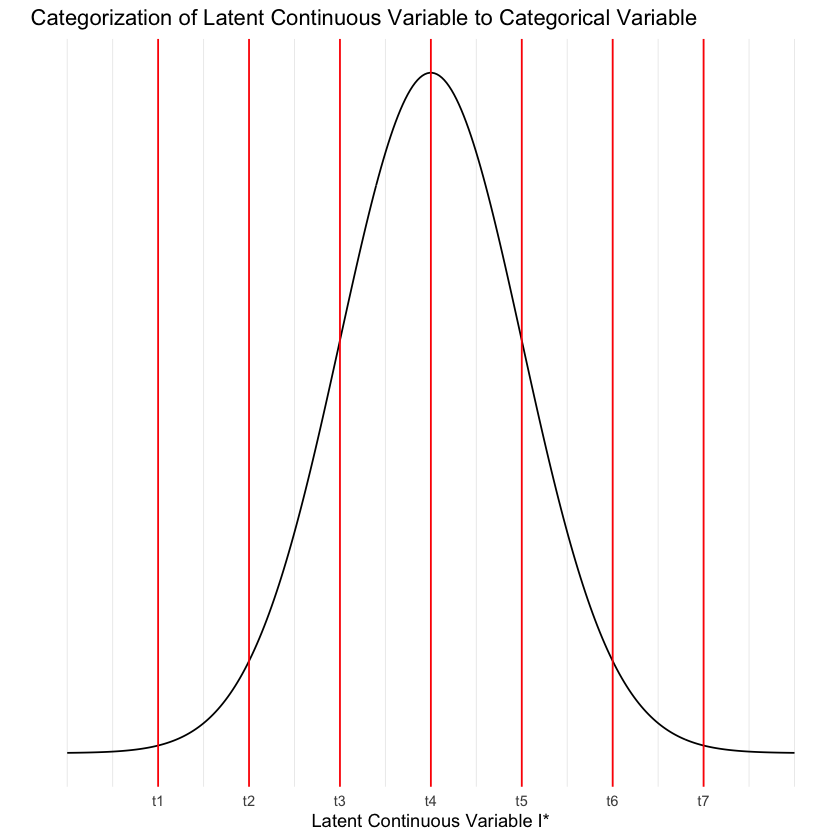

In [13]:
# Definire le soglie
thresholds <- c(-3, -2, -1, 0, 1, 2, 3)

# Creare un dataframe per la curva normale
x_values <- seq(-4, 4, length.out = 300)
y_values <- dnorm(x_values)
curve_data <- data.frame(x = x_values, y = y_values)

# Creare il plot
ggplot(curve_data, aes(x = x, y = y)) +
    geom_line() +
    geom_vline(xintercept = thresholds, col = "red") +
    scale_y_continuous(breaks = NULL) +
    scale_x_continuous(breaks = thresholds, labels = c("t1", "t2", "t3", "t4", "t5", "t6", "t7")) +
    labs(
        title = "Categorization of Latent Continuous Variable to Categorical Variable",
        x = "Latent Continuous Variable I*",
        y = ""
    ) +
    theme_minimal()


La conversione della variabile latente $ I^* $ in dati su una scala Likert comporta inevitabilmente degli errori di misurazione e campionamento. Come evidenziato da O'Brien (1985), questo processo di categorizzazione introduce due tipi principali di errore: 

1. **Errore di categorizzazione**: Questo errore deriva dalla segmentazione di una scala continua in una scala categoriale, dove la variabile latente viene divisa in categorie distinte.
   
2. **Errore di trasformazione**: Questo errore emerge quando le categorie hanno larghezze disuguali, influenzando la fedeltà della rappresentazione delle misure originali della variabile latente.

Di conseguenza, è fondamentale che le soglie siano stimate contemporaneamente agli altri parametri nel modello di equazioni strutturali per garantire che tali errori siano minimizzati e che l'analisi rifletta accuratamente la realtà sottostante.

### Modellazione di Variabili Categoriali nei Modelli CFA

Nell'ambito dei modelli CFA, le variabili categoriali ordinate vengono spesso modellate collegandole a una variabile latente sottostante, denominata $ I^* $. Questa variabile latente rappresenta una sorta di "propensione nascosta" che influisce sulle risposte osservate nelle variabili categoriali.

Per esemplificare, consideriamo il seguente modello che esprime la variabile latente $ I^* $ attraverso una serie di predittori (x1, x2, ..., xp), ognuno dei quali contribuisce all'esito con un effetto quantificato dai coefficienti $ \beta_1, \beta_2, ..., \beta_P $:

$$ 
I^*_i = \beta_0 + \beta_1 x_{1i} + \dots + \beta_P x_{Pi} + e_i.
$$

In questa equazione:
- $ I^*_i $ indica la propensione latente per l'osservatore $ i $.
- $ \beta_0 $ è un termine costante che agisce come intercetta.
- $ \beta_1, \dots, \beta_P $ sono i coefficienti che misurano l'impatto di ciascun predittore sulla propensione latente.
- $ e_i $ è il termine di errore che rappresenta le variazioni non spiegate dai predittori.

Quando la variabile categoriale $ I $ funge da indicatore di un fattore latente $ \xi $ in un modello fattoriale confermativo, la formulazione dell'equazione si semplifica a:

$$ 
I^*_i = \beta_0 + \beta_1 \xi_i + e_i.
$$

In questa configurazione, $ \beta_1 $ rappresenta il carico fattoriale, indicando quanto fortemente il fattore latente $ \xi $ influisce sulla variabile latente $ I^* $. Questo schema è analogo a quello usato per modellare indicatori di misurazione continui nei modelli SEM.

Questo approccio riflette l'idea che le risposte categoriali osservabili possono essere considerate come manifestazioni esterne di una propensione interna latente. Per la stima di tali modelli, il metodo dei minimi quadrati ponderati (WLS) è generalmente appropriato. Tuttavia, è importante tenere presente che la modellazione di risposte categoriali ordinate può richiedere considerazioni aggiuntive per gestire adeguatamente la loro natura ordinale, dettagli che verranno approfonditi nelle sezioni seguenti.

### Adattamento del Modello con `lmer`

Specifichiamo il modello nel modo seguente:

In [14]:
model1 <- '
  etoh =~ y1 + y2 + y3 + y4 + y5 + y6
'

Nell'analizzare dati ottenuti da scale ordinali, il software `lavaan` impiega un metodo specializzato per gestire la natura particolare dei dati categoriali. Questo approccio utilizza lo stimatore WLSMV (Weighted Least Squares Mean and Variance Adjusted). La stima dei parametri avviene tramite il metodo dei minimi quadrati ponderati diagonalmente (DWLS), che si concentra sulle componenti diagonali della matrice di peso. Questa specificità rende lo stimatore WLSMV particolarmente adatto per analizzare dati non normali.

Una caratteristica importante dello stimatore WLSMV è la sua capacità di calcolare errori standard robusti. Questi sono determinati attraverso un metodo che mantiene l'affidabilità delle stime anche quando i dati non soddisfano le tradizionali assunzioni di normalità. Inoltre, le statistiche di test prodotte da WLSMV sono adeguatamente corrette per tenere conto delle variazioni nella media e nella varianza dei dati. Questo tipo di correzione è cruciale per garantire l'accuratezza e la validità delle statistiche di test, specialmente quando la distribuzione dei dati devia dalla normalità.

In conclusione, `lavaan` offre un approccio avanzato per la modellazione di dati categoriali utilizzando lo stimatore WLSMV, che è ottimizzato per rispondere alle esigenze specifiche di questi tipi di dati. Questo si traduce in stime più precise e statistiche di test affidabili, rendendo `lavaan` uno strumento molto appropriato per l'analisi di dati categoriali complessi.

In [15]:
fit1 <- cfa(
  model1, 
  data = d1, 
  ordered = names(d1), 
  estimator = "WLSMVS", 
  mimic = "mplus"
)

Esaminiamo la soluzione ottenuta:

In [16]:
out = summary(fit1, fit.measures = TRUE)
print(out)

lavaan 0.6.17 ended normally after 16 iterations

  Estimator                                       DWLS
  Optimization method                           NLMINB
  Number of model parameters                        12

  Number of observations                           750

Model Test User Model:
                                                  Standard      Scaled
  Test Statistic                                     5.651       9.540
  Degrees of freedom                                     9           9
  P-value (Chi-square)                               0.774       0.389
  Scaling correction factor                                      0.592
    mean and variance adjusted correction (WLSMV)                     

Model Test Baseline Model:

  Test statistic                              1155.845     694.433
  Degrees of freedom                                15           9
  P-value                                        0.000       0.000
  Scaling correction factor                      

Si presti particolare attenzione alla seguente porzione dell'output:

```bash
                   Estimate  Std.Err  z-value  P(>|z|)
    y1|t1            -0.759    0.051  -14.890    0.000
    y2|t1            -0.398    0.047   -8.437    0.000
    y3|t1            -1.244    0.061  -20.278    0.000
    y4|t1            -0.795    0.051  -15.436    0.000
    y5|t1            -0.384    0.047   -8.148    0.000
    y6|t1            -0.818    0.052  -15.775    0.000
```

In questa porzione dell'output di `lavaan` sono presentati i risultati per le "soglie" (thresholds) relative alle variabili categoriali ordinate utilizzate nel modello SEM. Ecco una spiegazione dettagliata:

1. **Thresholds (Soglie)**:
   - Ogni soglia rappresenta un punto di cutoff lungo la variabile continua latente (indicata in precedenza come I*), che determina le categorie della variabile categoriale osservata.
   - Nell'output, `y1|t1`, `y2|t1`, ecc., rappresentano soglie per le variabili rispettive (y1, y2, ..., y6). Il termine "t1" si riferisce alla prima soglia per ciascuna di queste variabili.

2. **Estimate (Stima)**:
   - Questi valori indicano la posizione della soglia sulla scala della variabile continua latente. Per esempio, la soglia per y1 è a -0.759. Questo significa che la divisione tra le prime due categorie di y1 si verifica a -0.759 sulla scala della variabile latente.

3. **Std.Err (Errore Standard)**:
   - L'errore standard della stima di ogni soglia. Ad esempio, per y1, l'errore standard è 0.051. Questo offre un'idea della variabilità o incertezza nella stima della soglia.

4. **z-value**:
   - Il valore z indica il rapporto tra la stima della soglia e il suo errore standard. Un valore z elevato suggerisce che la stima della soglia è significativamente diversa da zero (ovvero, la soglia è ben definita). Per esempio, per y1, il valore z è -14.890, che è statisticamente significativo.

5. **P(>|z|)**:
   - Il p-value associato al valore z. Un p-value basso (ad esempio, 0.000) indica che la stima della soglia è statisticamente significativa. Questo significa che possiamo essere abbastanza sicuri che la posizione della soglia sulla variabile latente sia accurata e non dovuta al caso.

In sintesi, queste soglie consentono di trasformare la variabile latente continua in una variabile categoriale osservata nel modello. La stima di queste soglie e la loro significatività statistica sono cruciali per comprendere come la variabile latente si traduce nelle categorie osservate. 

Confrontiamo ora la soluzione ottenuta con lo stimatore WLSMVS con quella ottenuta mediante lo stimatore ML.

In [17]:
fit2 <- cfa(
  model1, 
  data = d1
)

In [18]:
out <- summary(fit2, fit.measures = TRUE)
print(out)

lavaan 0.6.17 ended normally after 35 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        12

  Number of observations                           750

Model Test User Model:
                                                      
  Test statistic                                14.182
  Degrees of freedom                                 9
  P-value (Chi-square)                           0.116

Model Test Baseline Model:

  Test statistic                               614.305
  Degrees of freedom                                15
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.991
  Tucker-Lewis Index (TLI)                       0.986

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -2087.600
  Loglikelihood unrestricted model (H1)      -20

Si noti che la soluzione ottenuta mediante lo stimatore WLSMVS produce indici di bontà di adattamento migliori e errori standard dei parametri più piccoli.

## Considerazioni Conclusive

In questo capitolo, abbiamo esplorato la modellazione CFA con dati non normalmente distribuiti. È essenziale riconoscere che, nella pratica analitica, incontrare dati non normalmente distribuiti dovrebbe essere considerato normale. Di conseguenza, si raccomanda l'utilizzo della massima verosimiglianza robusta (ML robusta) ogni volta che sorgono dubbi sulla normalità dei dati.

Ci sono alcune considerazioni importanti da tenere presente:
1. **Stabilità delle stime di parametro**: Anche se le versioni robuste di ML forniscono errori standard robusti e statistiche di test adattate, le stime dei parametri ottenute rimangono quelle della stima ML originale.
2. **Robustezza limitata**: Gli aggiustamenti robusti compensano la violazione della normalità, ma non coprono la presenza di valori anomali, che richiedono un'analisi separata.
3. **Limitazioni degli aggiustamenti**: Gli aggiustamenti robusti non trattano violazioni delle specifiche del modello, che è un altro argomento di discussione nella letteratura CFA e SEM.

Abbiamo anche discusso l'uso dello stimatore WLSMV per dati categoriali, evidenziando come esso fornisca una stima dell'errore standard più precisa rispetto all'MLE standard e all'MLE robusta.

Va notato che WLSMV è un metodo generale per dati categoriali nella CFA, ampiamente implementato in software come MPlus. In `lavaan`, l'uso di WLSMV può essere attivato semplicemente con `lavaan(..., estimator = "WLSMV")`, equivalente a `lavaan(..., estimator = "DWLS", se = "robust.sem", test = "scaled.shifted")`.

Oltre al WLSMV, `lavaan` offre anche lo stimatore sperimentale di massima verosimiglianza marginale (MML), che, pur essendo preciso, può essere lento e più suscettibile a problemi di convergenza a causa della complessità dell'integrazione numerica. Un altro stimatore è l'ADF (estimator = "WLS"), che non assume specifiche distributive sui dati, ma richiede una dimensione campionaria molto grande (N > 5000) per considerare affidabili le stime dei parametri, gli errori standard e le statistiche di test.

## Session Info

In [19]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.4.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggokabeito_0.1.0  viridis_0.6.5     viridisLite_0.4.2 ggpubr_0.6.0     
 [5] ggExtra_0.10.1    bayesplot_1.11.1  gridExtra_2.3     patchwork_1.2.0  
 [9] semTools_0.5-6    semPlot_1.1.6     lavaan_0.6-17     psych_2.4.3      
[13] scales_1.3.0      markdown_1.12     knitr_1.45        lubridate_1.9.3  
[17] forcats_1.0.0     stringr_1.5.1     dplyr_1.1.4       purrr_1.0.2      
[21] readr_2.1.5       tidyr_1.3.1       tibble_3.2.1      ggplot2_3.5.0    
[25] tidyvers